              precision    recall  f1-score   support

           0     0.9480    1.0000    0.9733       966
           1     1.0000    0.6443    0.7837       149

    accuracy                         0.9525      1115
   macro avg     0.9740    0.8221    0.8785      1115
weighted avg     0.9549    0.9525    0.9480      1115

ROC‑AUC: 0.9869


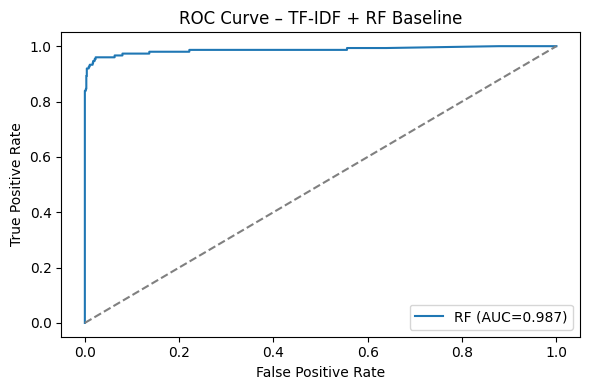

In [ ]:
# tfidf_rf_baseline.py
# requirements: scikit-learn, pandas, matplotlib

from typing import Tuple
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


def load_sms_spam(url: str) -> pd.DataFrame:
    """
    Load the SMS Spam collections from a TSV URL and map labels to integers.

    Parameters
    ----------
    url : str
        HTTP(S) URL pointing to a TSV file where first column is label ("ham"/"spam")
        and second column is the message text.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['label', 'text'] where label is 0 for ham and 1 for spam.

    Example
    -------
    df = load_sms_spam("https://.../sms.tsv")
    """
    df = pd.read_table(url, header=None, names=["label", "text"])
    df["label"] = df["label"].map({"ham": 0, "spam": 1})
    return df


def split_data(
    texts: pd.Series,
    labels: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """
    Stratified train-test split for text data.

    Parameters
    ----------
    texts : pd.Series
        Series of raw text documents.
    labels : pd.Series
        Series of corresponding integer labels.
    test_size : float
        Proportion for the test split.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    Tuple of (X_train, X_test, y_train, y_test)
    """
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state, stratify=labels)


def fit_tfidf_vectorizer(train_texts: pd.Series, max_features: int = 10_000):
    """
    Fit a TF-IDF vectorizer on training texts and return fitted vectorizer and transformed matrices.

    Parameters
    ----------
    train_texts : pd.Series
        Texts to fit the vectorizer on.
    max_features : int
        Maximum number of features to keep.

    Returns
    -------
    tuple: (vectorizer, X_train_tfidf)
    """
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(train_texts)
    return vectorizer, X_train_tfidf


def transform_with_vectorizer(vectorizer: TfidfVectorizer, texts: pd.Series):
    """
    Transform texts using a previously fitted TF-IDF vectorizer.

    Parameters
    ----------
    vectorizer : TfidfVectorizer
        A fitted TF-IDF vectorizer.
    texts : pd.Series
        Texts to transform.

    Returns
    -------
    sparse matrix
        TF-IDF representation of the texts.
    """
    return vectorizer.transform(texts)


def train_random_forest(X_train, y_train, n_estimators: int = 300, max_depth: int = 20, random_state: int = 42):
    """
    Train a RandomForestClassifier on precomputed features.

    Parameters
    ----------
    X_train : array-like or sparse matrix
        Training features.
    y_train : array-like
        Training labels.
    n_estimators : int
        Number of trees.
    max_depth : int
        Max depth of each tree.
    random_state : int
        Random seed.

    Returns
    -------
    RandomForestClassifier
        Fitted classifier.
    """
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf


def evaluate_classifier(clf, X_test, y_test) -> float:
    """
    Print classification metrics and return ROC-AUC.

    Parameters
    ----------
    clf : classifier with predict and predict_proba
        Trained classifier.
    X_test : array-like
        Test features.
    y_test : array-like
        True labels.

    Returns
    -------
    float
        ROC-AUC score on the test set.
    """
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred, digits=4))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    return roc_auc


def plot_roc_curve(y_test, y_score, title="ROC Curve – TF-IDF + RF Baseline"):
    """
    Plot ROC curve for binary classification.

    Parameters
    ----------
    y_test : array-like
        True binary labels.
    y_score : array-like
        Probability estimates for the positive class.
    title : str
        Plot title.

    Returns
    -------
    None
    """
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_score):.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
    df = load_sms_spam(url)
    X_train, X_test, y_train, y_test = split_data(df["text"], df["label"], test_size=0.2, random_state=42)

    vect, X_train_tfidf = fit_tfidf_vectorizer(X_train)
    X_test_tfidf = transform_with_vectorizer(vect, X_test)

    rf = train_random_forest(X_train_tfidf, y_train)
    roc_auc = evaluate_classifier(rf, X_test_tfidf, y_test)
    # Need probabilities for plotting ROC
    y_proba_test = rf.predict_proba(X_test_tfidf)[:, 1]
    plot_roc_curve(y_test, y_proba_test)


if __name__ == "__main__":
    main()


In [4]:
!pip install torch transformers scikit-learn shap onnx onnxruntime matplotlib

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
50,0.557500
100,0.269800
150,0.139000
200,0.087200
250,0.059700
300,0.074600
350,0.052600
400,0.050400
450,0.050900
500,0.076900


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



=== TinyBERT Fine‑tuning Metrics ===
eval_loss : 0.0587
eval_accuracy: 0.9874
eval_precision: 0.9655
eval_recall: 0.9396
eval_f1   : 0.9524
eval_roc_auc: 0.9939
eval_runtime: 0.6189
eval_samples_per_second: 1801.6100
eval_steps_per_second: 56.5530
epoch     : 3.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- RF on CLS embeddings ---
              precision    recall  f1-score   support

           0     0.9918    0.9959    0.9938       966
           1     0.9724    0.9463    0.9592       149

    accuracy                         0.9892      1115
   macro avg     0.9821    0.9711    0.9765      1115
weighted avg     0.9892    0.9892    0.9892      1115

RF ROC‑AUC: 0.9866883432684425

--- ANN on CLS embeddings ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9918    0.9959    0.9938       966
           1     0.9724    0.9463    0.9592       149

    accuracy                         0.9892      1115
   macro avg     0.9821    0.9711    0.9765      1115
weighted avg     0.9892    0.9892    0.9892      1115

ANN ROC‑AUC: 0.993476176580933

Quantized model saved: tinybert_spam_int8.pt


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Quantized PyTorch latency → mean 70.22 ms, 95th pct 91.94 ms


/usr/local/lib/python3.11/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1729: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  result = self.forward(*input, **kwargs)


Exported float ONNX model to tinybert_spam_float.onnx


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cpu


ONNX float latency → mean 70.66 ms, 95th pct 82.50 ms


  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 4/50 [00:14<01:18,  1.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:21<01:58,  2.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:28<02:57,  4.12s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [00:38<03:11,  4.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [00:51<03:31,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [00:58<03:43,  5.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [01:05<02:40,  4.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 15/50 [01:14<03:15,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [01:20<03:15,  5.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 17/50 [01:29<03:40,  6.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [01:53<01:30,  3.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [02:01<02:00,  4.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [02:06<01:57,  4.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [02:14<02:14,  5.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 29/50 [02:22<01:36,  4.61s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [02:27<01:37,  4.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [02:37<01:21,  4.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [02:52<00:50,  3.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [03:08<00:24,  2.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 42/50 [03:15<00:30,  3.87s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [03:28<00:20,  4.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [03:38<00:12,  4.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [03:53,  4.76s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 6/50 [00:17<01:21,  1.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:27<02:27,  3.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 9/50 [00:32<02:44,  4.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 11/50 [00:42<02:52,  4.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 12/50 [00:48<03:08,  4.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [00:54<02:11,  3.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 16/50 [01:06<02:40,  4.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 24/50 [01:33<01:17,  2.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 26/50 [01:44<01:39,  4.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 27/50 [01:49<01:43,  4.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 30/50 [02:00<01:14,  3.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 36/50 [02:19<00:39,  2.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 41/50 [02:32<00:18,  2.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 45/50 [02:49<00:18,  3.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [02:56<00:09,  3.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [03:08,  3.93s/it]



Mean SHAP‑Similarity (float vs quant): 0.2973
Saved SHAP summary bar chart → shap_summary_tokens.png


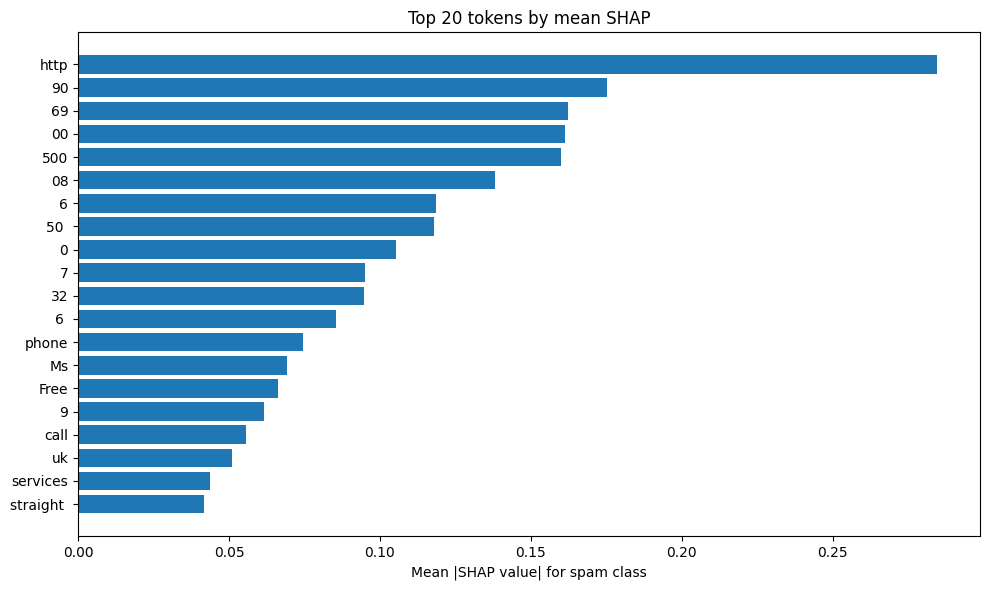

In [ ]:
# advanced_spam_tinybert.py
# requirements: transformers, torch, onnxruntime, shap, scikit-learn, matplotlib, pandas, numpy

import os
import time
import random
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.quantization import quantize_dynamic

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, roc_auc_score
import onnxruntime as ort
import shap
import matplotlib.pyplot as plt


SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed: int = SEED) -> None:
    """
    Make random behavior reproducible across python, numpy and torch.

    Parameters
    ----------
    seed : int
        Random seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def load_sms_dataset(url: str = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv") -> pd.DataFrame:
    """
    Load SMS Spam data from a TSV file and map labels to integers.

    Parameters
    ----------
    url : str
        URL or local path to TSV file with columns [label, text].

    Returns
    -------
    pd.DataFrame
        DataFrame with 'text' and 'label' columns.
    """
    df = pd.read_csv(url, sep="\t", header=None, names=["label", "text"])
    df["label"] = df["label"].map({"ham": 0, "spam": 1})
    return df


class SMSDataset(Dataset):
    """
    Simple torch Dataset that tokenizes a batch of texts up front.

    Parameters
    ----------
    texts : List[str]
        Raw text strings.
    labels : List[int]
        Integer labels per text.
    tokenizer :
        HuggingFace tokenizer instance.
    max_len : int
        Max token length to pad/truncate to.
    """

    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_len: int = 128):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=max_len,
            return_tensors="pt",
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


def load_model_and_tokenizer(model_name: str = "huawei-noah/TinyBERT_General_4L_312D"):
    """
    Load a pretrained sequence classification model and tokenizer.

    Parameters
    ----------
    model_name : str
        Name of the HuggingFace model.

    Returns
    -------
    tokenizer, model (moved to DEVICE)
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(DEVICE)
    return tokenizer, model


def compute_metrics_for_trainer(pred):
    """
    Compute metrics used by the HuggingFace Trainer during eval.

    Parameters
    ----------
    pred : EvalPrediction-like object
        Object with .predictions and .label_ids.

    Returns
    -------
    dict
        accuracy, precision, recall, f1, roc_auc
    """
    logits, labels = pred.predictions, pred.label_ids
    preds = np.argmax(logits, axis=1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc_score(labels, logits[:, 1]),
    }


def fine_tune_model(
    model,
    tokenizer,
    train_dataset,
    eval_dataset,
    output_dir: str = "./tinybert_spam",
    num_train_epochs: int = 3,
    per_device_train_batch_size: int = 16,
):
    """
    Fine-tune a transformer model using HuggingFace Trainer.

    Parameters
    ----------
    model :
        Pretrained model to fine-tune.
    tokenizer :
        Corresponding tokenizer.
    train_dataset, eval_dataset :
        torch.utils.data.Dataset instances prepared earlier.
    output_dir : str
        Directory to save checkpoints and logs.
    num_train_epochs : int
        Number of training epochs.
    per_device_train_batch_size : int
        Batch size per device.

    Returns
    -------
    Trainer
        Trained Trainer instance (trainer.model is updated).
    """
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=32,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_strategy="no",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics_for_trainer,
    )
    trainer.train()
    return trainer


def get_cls_embeddings(texts: List[str], tokenizer, model_base, max_length: int = 128) -> np.ndarray:
    """
    Compute CLS embeddings for a list of texts by forwarding through the base model.

    Parameters
    ----------
    texts : List[str]
        Raw texts to embed.
    tokenizer :
        HF tokenizer.
    model_base :
        Model block exposing last_hidden_state (e.g. model.base_model).
    max_length : int
        Tokenization max length.

    Returns
    -------
    np.ndarray
        Array of shape (len(texts), hidden_size) with CLS embeddings on CPU.
    """
    enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model_base(**enc)
    return out.last_hidden_state[:, 0, :].cpu().numpy()


def train_and_evaluate_classifiers(X_train: np.ndarray, y_train: List[int], X_test: np.ndarray, y_test: List[int]):
    """
    Train a RandomForest and a shallow MLP on embeddings and print reports.

    Parameters
    ----------
    X_train, X_test : np.ndarray
        Embedding matrices.
    y_train, y_test : List[int]
        Labels.

    Returns
    -------
    dict
        Dictionary with trained models and ROC-AUCs.
    """
    results = {}
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
    rf.fit(X_train, y_train)
    y_rf = rf.predict(X_test)
    rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    print("\n--- Random Forest on CLS embeddings ---")
    print(classification_report(y_test, y_rf, digits=4))
    print("RF ROC-AUC:", rf_auc)
    results["rf"] = (rf, rf_auc)

    ann = MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=SEED)
    ann.fit(X_train, y_train)
    y_ann = ann.predict(X_test)
    ann_auc = roc_auc_score(y_test, ann.predict_proba(X_test)[:, 1])
    print("\n--- MLP on CLS embeddings ---")
    print(classification_report(y_test, y_ann, digits=4))
    print("MLP ROC-AUC:", ann_auc)
    results["ann"] = (ann, ann_auc)

    return results


def quantize_and_benchmark(model, tokenizer, sample_texts: List[str], repeat: int = 100) -> Dict[str, float]:
    """
    Apply dynamic quantization to the model and benchmark inference latency.

    Parameters
    ----------
    model :
        A torch.nn.Module (assumes supports input_ids & attention_mask).
    tokenizer :
        HF tokenizer.
    sample_texts : List[str]
        A small list of texts to build a dummy batch for latency testing.
    repeat : int
        Number of runs to measure.

    Returns
    -------
    dict
        Mean and 95th percentile latency (ms) for the quantized model.
    """
    model_cpu = model.cpu()
    quant_model = quantize_dynamic(model_cpu, {nn.Linear}, dtype=torch.qint8)
    quant_model.eval()
    torch.save(quant_model.state_dict(), "tinybert_spam_int8.pt")

    dummy = tokenizer(sample_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    ids = dummy["input_ids"]
    mask = dummy["attention_mask"]

    times = []
    for _ in range(repeat):
        t0 = time.time()
        _ = quant_model(input_ids=ids, attention_mask=mask)
        times.append((time.time() - t0) * 1000.0)
    mean_ms = float(np.mean(times))
    p95_ms = float(np.percentile(times, 95))
    print(f"Quantized PyTorch latency → mean {mean_ms:.2f} ms, 95th pct {p95_ms:.2f} ms")
    return {"mean_ms": mean_ms, "p95_ms": p95_ms}


def export_to_onnx_and_benchmark(model, tokenizer, sample_texts: List[str], onnx_path: str = "tinybert_spam_float.onnx", repeat: int = 100) -> Dict[str, float]:
    """
    Export the given model (float) to ONNX and measure inference latency with ONNX Runtime.

    Parameters
    ----------
    model :
        Torch model on CPU.
    tokenizer :
        HF tokenizer.
    sample_texts : List[str]
        List of texts used to build dummy inputs.
    onnx_path : str
        Output ONNX filename.
    repeat : int
        Number of runs to measure latency.

    Returns
    -------
    dict
        Mean and 95th percentile latency in ms.
    """
    # Wrap model to expose forward(input_ids, attention_mask) returning logits
    class ONNXWrapper(torch.nn.Module):
        def __init__(self, m):
            super().__init__()
            self.m = m

        def forward(self, input_ids, attention_mask):
            return self.m(input_ids=input_ids, attention_mask=attention_mask).logits

    model_cpu = model.cpu()
    wrapper = ONNXWrapper(model_cpu)
    dummy = tokenizer(sample_texts, truncation=True, padding="max_length", max_length=128, return_tensors="np")

    torch.onnx.export(
        wrapper,
        (torch.from_numpy(dummy["input_ids"]), torch.from_numpy(dummy["attention_mask"])),
        onnx_path,
        input_names=["input_ids", "attention_mask"],
        output_names=["logits"],
        dynamic_axes={"input_ids": {0: "batch", 1: "seq"}, "attention_mask": {0: "batch", 1: "seq"}, "logits": {0: "batch"}},
        opset_version=14,
    )
    print(f"Exported float ONNX model to {onnx_path}")

    sess = ort.InferenceSession(onnx_path)
    # warm-up
    for _ in range(5):
        sess.run(None, {"input_ids": dummy["input_ids"], "attention_mask": dummy["attention_mask"]})

    times = []
    for _ in range(repeat):
        t0 = time.time()
        sess.run(None, {"input_ids": dummy["input_ids"], "attention_mask": dummy["attention_mask"]})
        times.append((time.time() - t0) * 1000.0)
    mean_ms = float(np.mean(times))
    p95_ms = float(np.percentile(times, 95))
    print(f"ONNX float latency → mean {mean_ms:.2f} ms, 95th pct {p95_ms:.2f} ms")
    return {"mean_ms": mean_ms, "p95_ms": p95_ms}


def compute_shap_similarity(model, quant_model, tokenizer, sample_texts: List[str], class_index: int = 1) -> float:
    """
    Compute a simple average cosine similarity between SHAP value vectors from float and quantized pipelines.

    Parameters
    ----------
    model : torch.nn.Module
        Float model on CPU.
    quant_model : torch.nn.Module
        Quantized model on CPU.
    tokenizer :
        HF tokenizer.
    sample_texts : List[str]
        Texts to explain.
    class_index : int
        Class index to compare (1 for spam positive class).

    Returns
    -------
    float
        Mean cosine similarity across the sample between the class-indexed SHAP vectors.
    """
    pipe_float = pipeline("text-classification", model=model.cpu(), tokenizer=tokenizer, device=-1, return_all_scores=True)
    pipe_quant = pipeline("text-classification", model=quant_model, tokenizer=tokenizer, device=-1, return_all_scores=True)

    expl_f = shap.Explainer(pipe_float)
    expl_q = shap.Explainer(pipe_quant)

    sv_f = expl_f(sample_texts)
    sv_q = expl_q(sample_texts)

    sims = []
    for v1, v2 in zip(sv_f.values, sv_q.values):
        vec1 = v1[:, class_index]
        vec2 = v2[:, class_index]
        denom = (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-9)
        sims.append(float(np.dot(vec1, vec2) / denom))
    mean_sim = float(np.mean(sims))
    print(f"Mean SHAP similarity (float vs quant) for class {class_index}: {mean_sim:.4f}")
    return mean_sim


def plot_shap_top_tokens(sv, top_k: int = 20, out_path: str = "shap_summary_tokens.png"):
    """
    Create a simple horizontal bar chart showing top tokens by mean absolute SHAP value.

    Parameters
    ----------
    sv :
        SHAP output object with .values and .data fields.
    top_k : int
        Number of top tokens to show.
    out_path : str
        Where to save the PNG file.

    Returns
    -------
    None
    """
    token_vals = {}
    for vals, tokens in zip(sv.values, sv.data):
        for tok, shap_row in zip(tokens, vals):
            token_vals.setdefault(tok, []).append(abs(shap_row[1]))

    avg_vals = {tok: float(np.mean(vs)) for tok, vs in token_vals.items()}
    top_tokens = sorted(avg_vals.items(), key=lambda x: x[1], reverse=True)[:top_k]
    tokens, scores = zip(*top_tokens)

    plt.figure(figsize=(10, 6))
    plt.barh(list(reversed(tokens)), list(reversed(scores)))
    plt.xlabel("Mean |SHAP value| for spam class")
    plt.title(f"Top {top_k} tokens by mean |SHAP value|")
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Saved SHAP summary bar chart → {out_path}")


def main():
    set_seed(SEED)

    # 1. Load data and split
    df = load_sms_dataset()
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])
    train_texts, train_labels = train_df["text"].tolist(), train_df["label"].tolist()
    test_texts, test_labels = test_df["text"].tolist(), test_df["label"].tolist()

    # 2. Model & tokenizer
    tokenizer, model = load_model_and_tokenizer()
    base = model.base_model if hasattr(model, "base_model") else getattr(model, "bert", model)

    # 3. Prepare datasets for Trainer
    train_ds = SMSDataset(train_texts, train_labels, tokenizer)
    test_ds = SMSDataset(test_texts, test_labels, tokenizer)

    # 4. Fine-tune (this may take a while)
    trainer = fine_tune_model(model, tokenizer, train_ds, test_ds)
    metrics = trainer.evaluate()
    print("\n=== TinyBERT Fine-tuning Metrics ===")
    for k, v in metrics.items():
        print(f"{k:10s}: {v:.4f}")

    # 5. Extract CLS embeddings
    model.eval()
    X_train_emb = get_cls_embeddings(train_texts, tokenizer, base)
    X_test_emb = get_cls_embeddings(test_texts, tokenizer, base)

    # 6. Train classical classifiers on embeddings
    results = train_and_evaluate_classifiers(X_train_emb, train_labels, X_test_emb, test_labels)

    # 7. Quantize and benchmark
    quant_results = quantize_and_benchmark(model, tokenizer, test_texts[:4], repeat=100)

    # 8. Export float model to ONNX and benchmark
    onnx_results = export_to_onnx_and_benchmark(model, tokenizer, test_texts[:4], onnx_path="tinybert_spam_float.onnx", repeat=100)

    # 9. SHAP explainability & similarity 
    model_cpu = model.cpu()
    quant_model = quantize_dynamic(model_cpu, {nn.Linear}, dtype=torch.qint8)
    sample = test_texts[:50] if len(test_texts) >= 50 else test_texts
    try:
        mean_sim = compute_shap_similarity(model_cpu, quant_model, tokenizer, sample, class_index=1)
       
        expl = shap.Explainer(pipeline("text-classification", model=model_cpu, tokenizer=tokenizer, device=-1, return_all_scores=True))
        sv_f = expl(sample)
        plot_shap_top_tokens(sv_f, top_k=20, out_path="shap_summary_tokens.png")
    except Exception as e:
        print("SHAP explainability step failed (this can happen if shap or the pipeline isn't available):", str(e))


if __name__ == "__main__":
    main()
